In [712]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [713]:
TIME = 'timestamp'
ANCHOR = 'anchor'
FSIZE = 'file_size_kb'
RELAY = 'relay'
TIMES = 'times'

MEAN = "mean"
VARIANCE = "variance"
STD = "standard deviation"
MEAD = "mean absolute deviation"
MAD = "median absolute deviation"

SITE = "website"
SCHEME = "scheme"
SCORE = "score"
PA = "PA"

## 1. Data Collection

### 1.1. Example Raw Data on graph

In [714]:
# Get Dataframe from raw JSON measurements file
def getDataFrame(path_to_json):
    jsons = []
    
    with open(path_to_json) as f:
        for line in f:
            jsons.append(json.loads(line))
        
    timestamps = []
    anchors = []
    file_sizes = []
    relays = []
    times = []
    
    for row in jsons:
        timestamps.append(row[TIME])
        anchors.append(row[ANCHOR])
        file_sizes.append(row[FSIZE])
        relays.append(row[RELAY])
        times.append(row[TIMES])
        
    df = pd.DataFrame()
    df[TIME] = timestamps
    df[RELAY] = relays
    df[ANCHOR] = anchors
    df[FSIZE] = file_sizes
    df[TIMES] = times
    return df

df_raw = getDataFrame('data_collection/data_history/81000_line_measuremetnts.json')
print(f'Shape: {df_raw.shape}')
print(f'Unique relays: {df_raw[RELAY].unique().shape[0]}')

Shape: (81008, 5)
Unique relays: 7395


In [715]:
# Wanted columns
cols = [TIME, RELAY, TIMES]

# Select N instances
offset = 0
N = 5
df_1_1 = df_raw[cols].iloc[offset:offset+N].reset_index()

# Format timestamps
df_1_1[TIME] = df_1_1[TIME].apply(lambda x: x.replace('T', ''))
df_1_1[TIME] = df_1_1[TIME].apply(lambda x: x.split('.')[0])

# Format relay names
df_1_1[RELAY] = [f"Relay {i+1}" for i in range(N)]

# Format times
df_1_1[TIMES] = df_1_1[TIMES].apply(lambda x: [round(t, 3) for t in x])

# Add Mean
df_1_1[MEAN] = df_1_1[TIMES].apply(np.mean)

# Add deviation
df_1_1['deviation'] = df_1_1[TIMES].apply(lambda x: [max(x),min(x)])

In [716]:
print(df_1_1.to_string())

   index             timestamp    relay                                                                   times    mean       deviation
0      0  2021-02-24  13:16:26  Relay 1   [0.596, 0.608, 0.672, 0.646, 0.726, 0.757, 0.797, 0.723, 0.64, 0.735]  0.6900  [0.797, 0.596]
1      1  2021-02-24  13:16:34  Relay 2    [0.272, 0.223, 0.361, 0.297, 0.247, 0.308, 0.419, 0.357, 0.229, 0.3]  0.3013  [0.419, 0.223]
2      2  2021-02-24  13:16:37  Relay 3     [0.164, 0.257, 0.292, 0.27, 0.252, 0.244, 0.289, 0.26, 0.31, 0.288]  0.2626   [0.31, 0.164]
3      3  2021-02-24  13:16:40  Relay 4  [0.592, 0.592, 0.603, 0.589, 0.604, 0.714, 0.589, 0.658, 0.629, 0.715]  0.6285  [0.715, 0.589]
4      4  2021-02-24  13:16:47  Relay 5   [0.167, 0.216, 0.234, 0.295, 0.272, 0.276, 0.248, 0.253, 0.24, 0.236]  0.2437  [0.295, 0.167]


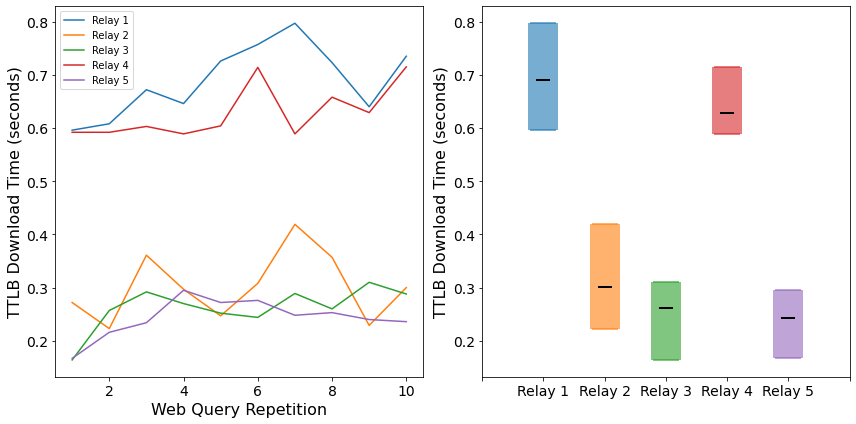

In [717]:
x_axis = [i+1 for i in range(10)]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# First axis
for i in range(N):
    ax1.plot(x_axis, df_1_1[TIMES][i], label=df_1_1[RELAY][i])
    
ax1.set_xlabel("Web Query Repetition", size=16)
ax1.set_ylabel("TTLB Download Time (seconds)", size=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend()



# Second Axis
relays = df_1_1[RELAY]
means = df_1_1[MEAN]
y_errors = df_1_1['deviation']

ax2.plot(relays, means, '_', markersize=14, markeredgewidth=2, color='black')

for i in range(N):
    err_top = y_errors[i][0] - means[i]
    err_bot = means[i] - y_errors[i][1]
#     err = [[err_top], [err_bot]]
    err = [[err_bot], [err_top]]
    ax2.errorbar(i, means[i], yerr=err, lw=3, capsize=13, capthick=2, elinewidth=30, alpha=0.6)

    
# ax2.set_xlabel("Relay Number", size=16)
ax2.set_xticks([-1,0,1,2,3,4,5])
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.labelsize = 18
ax2.set_ylabel("TTLB Download Time (seconds)", size=16)

plt.tight_layout()

plt.savefig('../graphics/five_relay_data_example.png')
plt.show()

---
---

### 1.2. Relay Scores Example

In [718]:
df_scores = pd.read_csv("data_collection/data_history/relay_scores.csv")


df_1_2 = df_scores.iloc[0:5].reset_index().drop('index', axis=1)

df_1_2[RELAY] = [f"Relay {i+1}" for i in range(5)]

print(df_1_2.to_string())

     relay      mean  variance  standard deviation  mean absolute deviation  median absolute deviation
0  Relay 1  0.492455  0.029510            0.128610                 0.081096                   0.035464
1  Relay 2  1.030715  0.280544            0.233164                 0.158150                   0.096350
2  Relay 3  0.976972  0.013808            0.090172                 0.065970                   0.047498
3  Relay 4  0.543491  0.002413            0.044977                 0.029468                   0.012439
4  Relay 5  1.202045  0.175096            0.220917                 0.182632                   0.177604


---
---

### 1.3. Relay scores vs Consensus BWs

In [719]:
# Get consensus
df_consensus = pd.read_csv('data_collection/last_consensus.csv')


In [720]:
# Get df with scores and published bws that are common for relays
df_1_3 = df_scores[df_scores[RELAY].isin(df_consensus[RELAY])]

d = {f:b for f,b in zip(df_consensus[RELAY], df_consensus['bandwidth'])}
df_1_3['bw'] = df_1_3[RELAY].map(d)

/Users/axo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


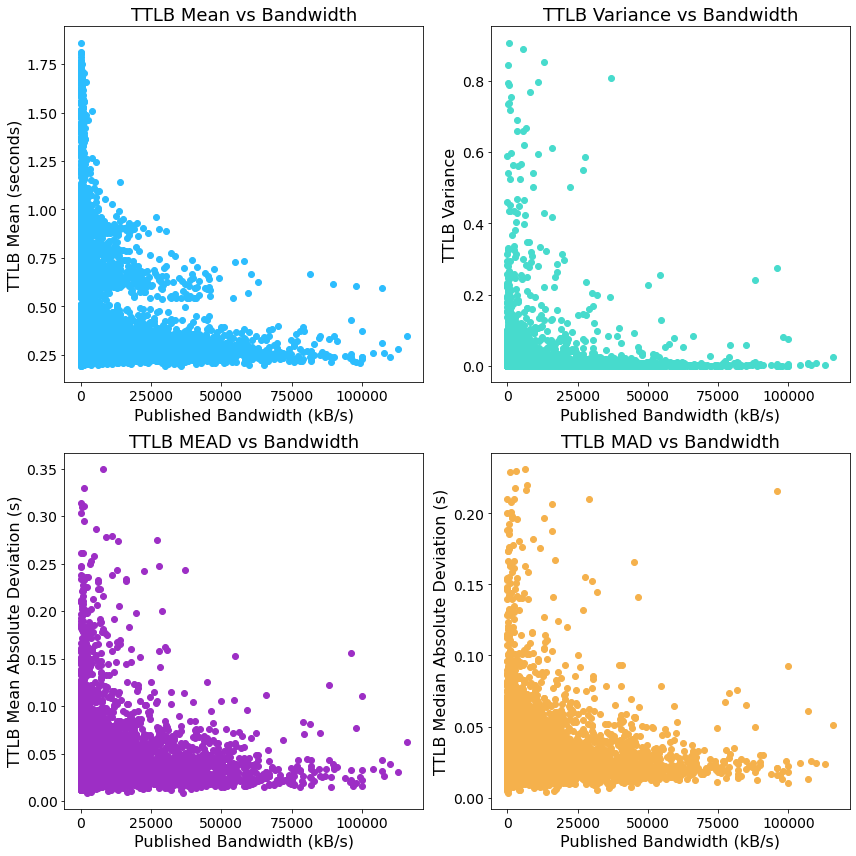

In [721]:
# Filter for prettyness
df_1_3 = df_1_3[df_1_3['bw'] < 120000]
df_1_3 = df_1_3[df_1_3[VARIANCE] < 1]
df_1_3 = df_1_3[df_1_3[MAD] < 0.25]
df_1_3 = df_1_3[df_1_3[MEAD] < 0.35]


# Common
bws = df_1_3['bw']
x_label = "Published Bandwidth (kB/s)"

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'


f, ax = plt.subplots(2, 2, figsize=(12,12))


# mean
ax[0][0].scatter(bws, df_1_3[MEAN], color=CB91_Blue)
ax[0][0].set_title("TTLB Mean vs Bandwidth", size=18)
ax[0][0].set_xlabel(x_label, size=16)
ax[0][0].set_ylabel("TTLB Mean (seconds)", size=16)
# ax[0][0].set_xticklabels([])
ax[0][0].set_xticks([0, 25000, 50000, 75000, 100000])
ax[0][0].tick_params(axis='both', which='major', labelsize=14)


# variance
ax[0][1].scatter(bws, df_1_3[VARIANCE], color=CB91_Green)
ax[0][1].set_title("TTLB Variance vs Bandwidth", size=18)
ax[0][1].set_xlabel(x_label, size=16)
ax[0][1].set_ylabel("TTLB Variance", size=16)
# ax[0][1].set_xticklabels([])
ax[0][1].set_xticks([0, 25000, 50000, 75000, 100000])
ax[0][1].tick_params(axis='both', which='major', labelsize=14)


# Mean average deviation
ax[1][0].scatter(bws, df_1_3[MEAD], color=CB91_Purple)
ax[1][0].set_title("TTLB MEAD vs Bandwidth", size=18)
ax[1][0].set_xlabel(x_label, size=16)
ax[1][0].set_ylabel("TTLB Mean Absolute Deviation (s)", size=16)
ax[1][0].set_xticks([0, 25000, 50000, 75000, 100000])
ax[1][0].tick_params(axis='both', which='major', labelsize=14)


# Median Average deviation
ax[1][1].scatter(bws, df_1_3[MAD], color=CB91_Amber)
ax[1][1].set_title("TTLB MAD vs Bandwidth", size=18)
ax[1][1].set_xlabel(x_label, size=16)
ax[1][1].set_ylabel("TTLB Median Absolute Deviation (s)", size=16)
ax[1][1].set_xticks([0, 25000, 50000, 75000, 100000])
ax[1][1].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

plt.savefig('../graphics/scores_vs_bw.png')
plt.show()

---
---

## 2. Evaluation

### 2.1. Times taken for some websites for different score metrics


In [722]:
df_ev = pd.read_csv('evaluation.csv', converters={'times': eval})
ex = pd.read_csv('evaluation.csv', converters={'times': eval})

In [723]:
# Choose websites
w1 = 'youtube.com'
w2 = 'bbc.co.uk'

In [724]:
def deleteNHighest(l, n):
    ordered = sorted(list(l))
    keep = ordered[:-n]
    
    return [x for x in l if x in keep]

In [797]:
# Get Raw Graph Data

#w1
w1_times_vanilla = list(ex[(ex[SITE]==w1) & (ex[SCHEME]=="vanilla")][TIMES])[0]
w1_times_fastor_mean = list(ex[(ex[SITE]==w1) & (ex[SCHEME]=="fastor") & (ex[SCORE]==MEAN) & (ex[PA]==0)][TIMES])[0]
w1_times_fastor_var = list(ex[(ex[SITE]==w1) & (ex[SCHEME]=="fastor") & (ex[SCORE]==VARIANCE) & (ex[PA]==0)][TIMES])[0]
w1_times_fastor_mad = list(ex[(ex[SITE]==w1) & (ex[SCHEME]=="fastor") & (ex[SCORE]=='mad') & (ex[PA]==0)][TIMES])[0]
w1_num_points = min( len(w1_times_vanilla), len(w1_times_fastor_mean), len(w1_times_fastor_var), len(w1_times_fastor_mad) )

#w2
w2_times_vanilla = list(ex[(ex[SITE]==w2) & (ex[SCHEME]=="vanilla")][TIMES])[0]
w2_times_fastor_mean = list(ex[(ex[SITE]==w2) & (ex[SCHEME]=="fastor") & (ex[SCORE]==MEAN) & (ex[PA]==0)][TIMES])[0]
w2_times_fastor_var = list(ex[(ex[SITE]==w2) & (ex[SCHEME]=="fastor") & (ex[SCORE]==VARIANCE) & (ex[PA]==0)][TIMES])[0]
w2_times_fastor_mad = list(ex[(ex[SITE]==w2) & (ex[SCHEME]=="fastor") & (ex[SCORE]=='mad') & (ex[PA]==0)][TIMES])[0]
w2_num_points = min( len(w2_times_vanilla), len(w2_times_fastor_mean), len(w2_times_fastor_var), len(w2_times_fastor_mad) )

# Drop slowest point for each one (For better visualization purposes)
w1_times_vanilla = deleteNHighest(w1_times_vanilla, 1)
w1_times_fastor_mean = deleteNHighest(w1_times_fastor_mean, 1)
w1_times_fastor_var = deleteNHighest(w1_times_fastor_var, 1)
w1_times_fastor_mad = deleteNHighest(w1_times_fastor_mad, 1)

w2_times_vanilla = deleteNHighest(w2_times_vanilla, 1)
w2_times_fastor_mean = deleteNHighest(w2_times_fastor_mean, 1)
w2_times_fastor_var = deleteNHighest(w2_times_fastor_var, 1)
w2_times_fastor_mad = deleteNHighest(w2_times_fastor_mad, 1)


# Shorten the bigger 3 lists
w1_times_vanilla = w1_times_vanilla[:w1_num_points]
w1_times_fastor_mean = w1_times_fastor_mean[:w1_num_points]
w1_times_fastor_var = w1_times_fastor_var[:w1_num_points]
w1_times_fastor_mad = w1_times_fastor_mad[:w1_num_points]

w2_times_vanilla = w2_times_vanilla[:w2_num_points]
w2_times_fastor_mean = w2_times_fastor_mean[:w2_num_points]
w2_times_fastor_var = w2_times_fastor_var[:w2_num_points]
w2_times_fastor_mad = w2_times_fastor_mad[:w2_num_points]


In [798]:
# Get average graph data
# w1
w1_avg_vanilla = np.mean(w1_times_vanilla)
w1_err_vanilla = np.std(w1_times_vanilla)

w1_avg_fastor_mean = np.mean(w1_times_fastor_mean)
w1_err_fastor_mean = np.std(w1_times_fastor_mean)

w1_avg_fastor_var = np.mean(w1_times_fastor_var)
w1_err_fastor_var = np.std(w1_times_fastor_var)

w1_avg_fastor_mad = np.mean(w1_times_fastor_mad)
w1_err_fastor_mad = np.std(w1_times_fastor_mad)


# w2
w2_avg_vanilla = np.mean(w2_times_vanilla)
w2_err_vanilla = np.std(w2_times_vanilla)

w2_avg_fastor_mean = np.mean(w2_times_fastor_mean)
w2_err_fastor_mean = np.std(w2_times_fastor_mean)

w2_avg_fastor_var = np.mean(w2_times_fastor_var)
w2_err_fastor_var = np.std(w2_times_fastor_var)

w2_avg_fastor_mad = np.mean(w2_times_fastor_mad)
w2_err_fastor_mad = np.std(w2_times_fastor_mad)


In [799]:
def plotErrorBar(ax, i, marker, err, label=''):
#     ax.errorbar(i, marker, yerr=err, fmt='_', markersize=8, markeredgewidth=2, lw=3, capsize=15, capthick=2, elinewidth=34, alpha=0.7, label=label)
    ax.bar(i, marker, yerr=err, align='center', alpha=0.6, capsize=10, label=label)

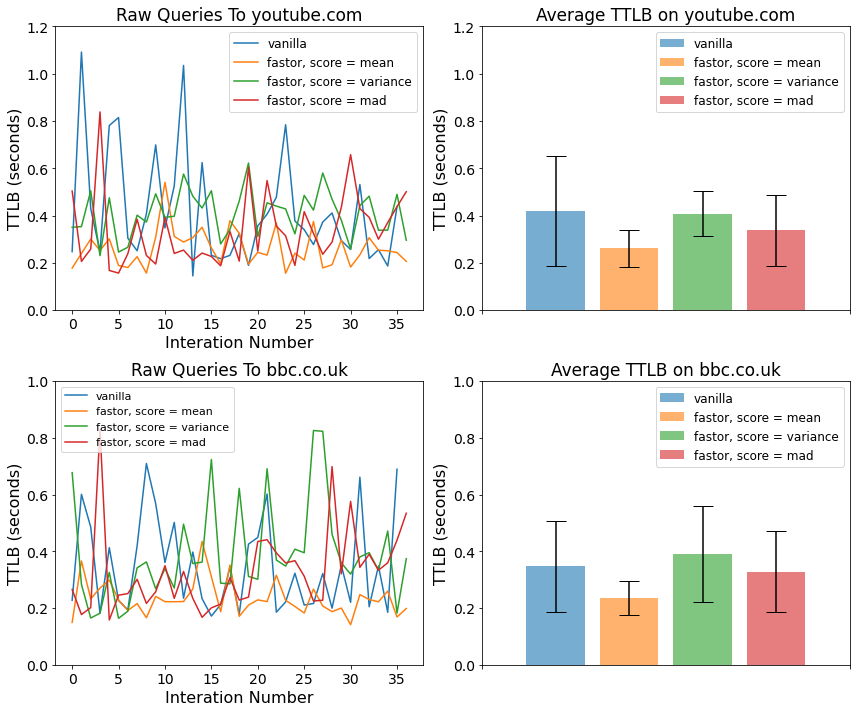

In [805]:
# GRAPH

f, ax = plt.subplots(2, 2, figsize=(12,10))


## w1 ##
ticks = [x/10 for x in range(0, 13, 2)]

# raw
ax[0][0].plot(w1_times_vanilla, label='vanilla')
ax[0][0].plot(w1_times_fastor_mean, label='fastor, score = mean')
ax[0][0].plot(w1_times_fastor_var, label='fastor, score = variance')
ax[0][0].plot(w1_times_fastor_mad, label='fastor, score = mad')

ax[0][0].set_title('Raw Queries To youtube.com', size=17)
ax[0][0].set_xlabel('Interation Number', size=16)
ax[0][0].set_ylabel('TTLB (seconds)', size=16)
ax[0][0].set_yticks(ticks)
ax[0][0].tick_params(axis='both', which='major', labelsize=14)

ax[0][0].legend(fontsize=12)


# Performance
plotErrorBar(ax[0][1], 1, w1_avg_vanilla, w1_err_vanilla, label='vanilla')
plotErrorBar(ax[0][1], 2, w1_avg_fastor_mean, w1_err_fastor_mean, label='fastor, score = mean')
plotErrorBar(ax[0][1], 3, w1_avg_fastor_var, w1_err_fastor_var, label='fastor, score = variance')
plotErrorBar(ax[0][1], 4, w1_avg_fastor_mad, w1_err_fastor_mad, label='fastor, score = mad')

ax[0][1].set_title('Average TTLB on youtube.com', size=17)
ax[0][1].set_ylabel('TTLB (seconds)', size=16)
ax[0][1].set_xticks([0,5])
ax[0][1].set_xticklabels([])
ax[0][1].set_yticks(ticks)
ax[0][1].tick_params(axis='both', which='major', labelsize=14)

ax[0][1].legend(fontsize=12)


## w2 ##
ticks = [x/10 for x in range(0, 11, 2)]

# Raw
ax[1][0].plot(w2_times_vanilla, label='vanilla')
ax[1][0].plot(w2_times_fastor_mean, label='fastor, score = mean')
ax[1][0].plot(w2_times_fastor_var, label='fastor, score = variance')
ax[1][0].plot(w2_times_fastor_mad, label='fastor, score = mad')

ax[1][0].set_title('Raw Queries To bbc.co.uk', size=17)
ax[1][0].set_xlabel('Interation Number', size=16)
ax[1][0].set_ylabel('TTLB (seconds)', size=16)
ax[1][0].set_yticks(ticks)
ax[1][0].tick_params(axis='both', which='major', labelsize=14)

ax[1][0].legend(fontsize=11)


# Performance
plotErrorBar(ax[1][1], 1, w2_avg_vanilla, w2_err_vanilla, label='vanilla')
plotErrorBar(ax[1][1], 2, w2_avg_fastor_mean, w2_err_fastor_mean, label='fastor, score = mean')
plotErrorBar(ax[1][1], 3, w2_avg_fastor_var, w2_err_fastor_var, label='fastor, score = variance')
plotErrorBar(ax[1][1], 4, w2_avg_fastor_mad, w2_err_fastor_mad, label='fastor, score = mad')

ax[1][1].set_title('Average TTLB on bbc.co.uk', size=17)
ax[1][1].set_ylabel('TTLB (seconds)', size=16)
ax[1][1].set_xticks([0,5])
ax[1][1].set_xticklabels([])
ax[1][1].set_yticks(ticks)
ax[1][1].tick_params(axis='both', which='major', labelsize=14)

ax[1][1].legend(fontsize=12)

plt.tight_layout()

plt.savefig('../graphics/results_2_websites.png')
plt.show()

---
---

### 2.2. Compare total web statistics between different client scheme setups

In [806]:
ttlb_vanilla = np.mean(df_ev[df_ev[SCHEME]=="vanilla"][MEAN])
ttlb_vanilla_std = np.mean(df_ev[df_ev[SCHEME]=="vanilla"][STD])/2



ttlb_mean_0 = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==0)][MEAN])
ttlb_mean_05 = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==0.5)][MEAN])
ttlb_mean_1 = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==1)][MEAN])

ttlb_mean_0_std = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==0)][STD])/2
ttlb_mean_05_std = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==0.5)][STD])/2
ttlb_mean_1_std = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==1)][STD])/2



ttlb_var_0 = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==0)][MEAN])
ttlb_var_05 = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==0.5)][MEAN])
ttlb_var_1 = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==1)][MEAN])

ttlb_var_0_std = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==0)][STD])/2
ttlb_var_05_std = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==0.5)][STD])/2
ttlb_var_1_std = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==1)][STD])/2



ttlb_mad_0 = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==0)][MEAN])
ttlb_mad_05 = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==0.5)][MEAN])
ttlb_mad_1 = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==1)][MEAN])

ttlb_mad_0_std = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==0)][STD])/2
ttlb_mad_05_std = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==0.5)][STD])/2
ttlb_mad_1_std = np.mean(df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==1)][STD])/2



In [807]:
def plotBar(ax, i, marker, label=''):
#     ax.errorbar(i, marker, yerr=err, fmt='_', markersize=8, markeredgewidth=2, lw=3, capsize=15, capthick=2, elinewidth=34, alpha=0.7, label=label)
    ax.bar(i, marker, align='center', alpha=0.6, label=label)

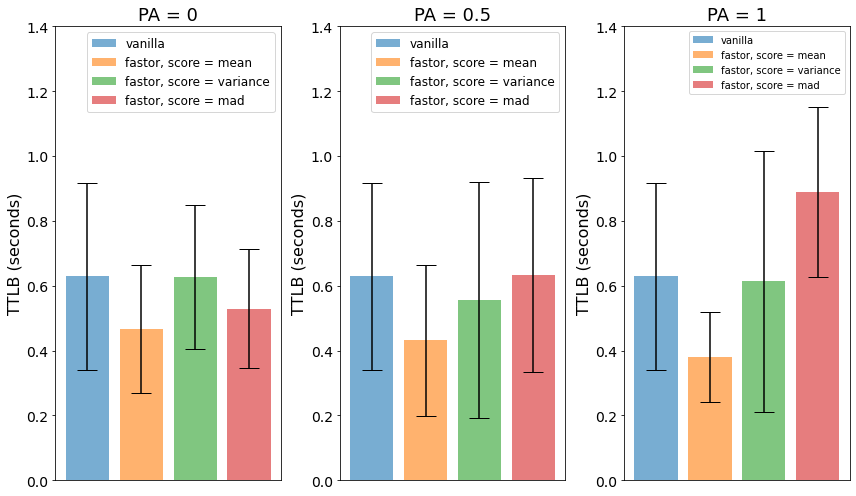

In [808]:
## Graph TTLBs of schemes

f, ax = plt.subplots(1, 3, figsize=(12,7))
# f.suptitle("Mean TTLB Using Different PA Parameters", fontsize=20)


# PA = 0
plotErrorBar(ax[0], 1, ttlb_vanilla, ttlb_vanilla_std, label='vanilla')
plotErrorBar(ax[0], 2, ttlb_mean_0, ttlb_mean_0_std, label='fastor, score = mean')
plotErrorBar(ax[0], 3, ttlb_var_0, ttlb_var_0_std, label='fastor, score = variance')
plotErrorBar(ax[0], 4, ttlb_mad_0, ttlb_mad_0_std, label='fastor, score = mad')
ax[0].set_title('PA = 0', size=18)
ax[0].set_ylabel("TTLB (seconds)", size=16)
ax[0].set_yticks([x/10 for x in range(0, 16, 2)])
ax[0].set_xticks([])
ax[0].tick_params(axis='both', which='major', labelsize=14)

ax[0].legend(fontsize=12)


# PA = 0.5
plotErrorBar(ax[1], 1, ttlb_vanilla, ttlb_vanilla_std, label='vanilla')
plotErrorBar(ax[1], 2, ttlb_mean_05, ttlb_mean_05_std, label='fastor, score = mean')
plotErrorBar(ax[1], 3, ttlb_var_05, ttlb_var_05_std, label='fastor, score = variance')
plotErrorBar(ax[1], 4, ttlb_mad_05, ttlb_mad_05_std, label='fastor, score = mad')
ax[1].set_title('PA = 0.5', size=18)
ax[1].set_ylabel("TTLB (seconds)", size=16)
ax[1].set_yticks([x/10 for x in range(0, 16, 2)])
ax[1].set_xticks([])
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].legend(fontsize=12)


# PA = 1
plotErrorBar(ax[2], 1, ttlb_vanilla, ttlb_vanilla_std, label='vanilla')
plotErrorBar(ax[2], 2, ttlb_mean_1, ttlb_mean_1_std, label='fastor, score = mean')
plotErrorBar(ax[2], 3, ttlb_var_1, ttlb_var_1_std, label='fastor, score = variance')
plotErrorBar(ax[2], 4, ttlb_mad_1, ttlb_mad_1_std, label='fastor, score = mad')
ax[2].set_title('PA = 1', size=18)
ax[2].set_ylabel("TTLB (seconds)", size=16)
ax[2].set_yticks([x/10 for x in range(0, 16, 2)])
ax[2].set_xticks([])
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].legend()

plt.tight_layout()
# plt.subplots_adjust(top=0.85)

plt.savefig('../graphics/TTLB_results_absolute.png')

plt.show()

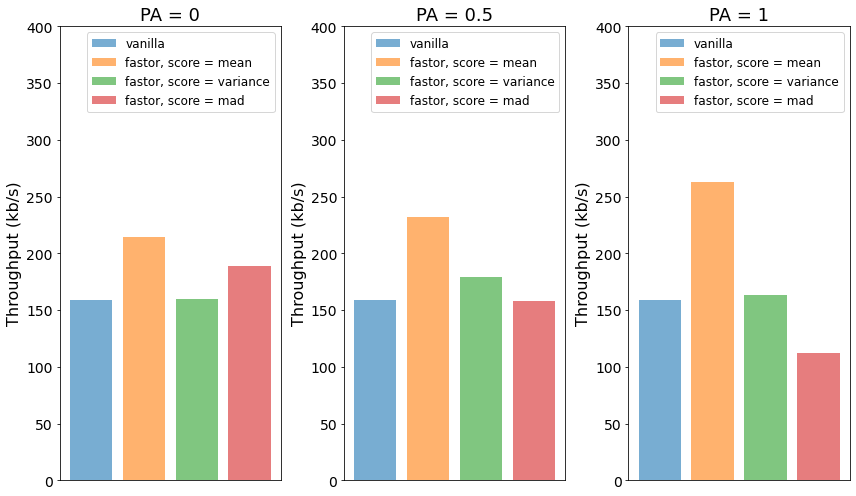

In [809]:
## Graph TTLBs of schemes

f, ax = plt.subplots(1, 3, figsize=(12,7))
# f.suptitle("Mean Throughput Using Different PA Parameters", fontsize=20)


# PA = 0
plotBar(ax[0], 1, 100/ttlb_vanilla, label='vanilla')
plotBar(ax[0], 2, 100/ttlb_mean_0, label='fastor, score = mean')
plotBar(ax[0], 3, 100/ttlb_var_0, label='fastor, score = variance')
plotBar(ax[0], 4, 100/ttlb_mad_0, label='fastor, score = mad')
ax[0].set_title('PA = 0', size=18)
ax[0].set_ylabel("Throughput (kb/s)", size=16)
ax[0].set_yticks([x for x in range(0, 401, 50)])
ax[0].set_xticks([])
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend(fontsize=12)


# PA = 0.5
plotBar(ax[1], 1, 100/ttlb_vanilla, label='vanilla')
plotBar(ax[1], 2, 100/ttlb_mean_05, label='fastor, score = mean')
plotBar(ax[1], 3, 100/ttlb_var_05, label='fastor, score = variance')
plotBar(ax[1], 4, 100/ttlb_mad_05, label='fastor, score = mad')
ax[1].set_title('PA = 0.5', size=18)
ax[1].set_ylabel("Throughput (kb/s)", size=16)
ax[1].set_yticks([x for x in range(0, 401, 50)])
ax[1].set_xticks([])
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].legend(fontsize=12)


# PA = 1
plotBar(ax[2], 1, 100/ttlb_vanilla, label='vanilla')
plotBar(ax[2], 2, 100/ttlb_mean_1, label='fastor, score = mean')
plotBar(ax[2], 3, 100/ttlb_var_1, label='fastor, score = variance')
plotBar(ax[2], 4, 100/ttlb_mad_1, label='fastor, score = mad')
ax[2].set_title('PA = 1', size=18)
ax[2].set_ylabel("Throughput (kb/s)", size=16)
ax[2].set_yticks([x for x in range(0, 401, 50)])
ax[2].set_xticks([])
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].legend(fontsize=12)

plt.tight_layout()
# plt.subplots_adjust(top=0.85)

plt.savefig('../graphics/throughput_results_absolute.png')

plt.show()

## RETRY

In [810]:
def getPercDifference(s1, s2):
    diff_s = s2 - s1
    perc_s = 100 * (diff_s / s1)
    return np.mean(perc_s)
    

In [811]:
ttlb_vanilla = df_ev[df_ev[SCHEME]=="vanilla"].sort_values(SITE).reset_index()[MEAN]

ttlb_mean_0 = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==0)].sort_values(SITE).reset_index()[MEAN])
ttlb_mean_05 = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==0.5)].sort_values(SITE).reset_index()[MEAN])
ttlb_mean_1 = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==1)].sort_values(SITE).reset_index()[MEAN])

ttlb_var_0 = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==0)].sort_values(SITE).reset_index()[MEAN])
ttlb_var_05 = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==0.5)].sort_values(SITE).reset_index()[MEAN])
ttlb_var_1 = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==1)].sort_values(SITE).reset_index()[MEAN])

ttlb_mad_0 = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==0)].sort_values(SITE).reset_index()[MEAN])
ttlb_mad_05 = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==0.5)].sort_values(SITE).reset_index()[MEAN])
ttlb_mad_1 = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==1)].sort_values(SITE).reset_index()[MEAN])

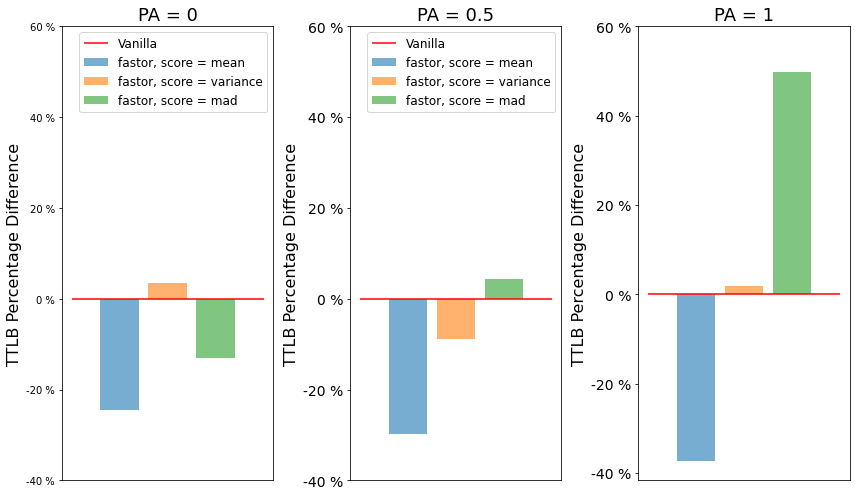

In [812]:
## Graph TTLBs of schemes

f, ax = plt.subplots(1, 3, figsize=(12,7))
# f.suptitle("Mean TTLB Difference from Vanilla", fontsize=20)

ax[0].hlines(0, 1, 5, label='Vanilla', color='red')
ax[1].hlines(0, 1, 5, label='Vanilla', color='red')
ax[2].hlines(0, 1, 5, label='Vanilla', color='red')

# PA = 0
# plotBar(ax[0], 1, ttlb_vanilla, label='vanilla')
plotBar(ax[0], 2, ttlb_mean_0, label='fastor, score = mean')
plotBar(ax[0], 3, ttlb_var_0, label='fastor, score = variance')
plotBar(ax[0], 4, ttlb_mad_0, label='fastor, score = mad')
ax[0].set_title('PA = 0', size=18)
ax[0].set_ylabel("TTLB Percentage Difference", size=16)
ax[0].set_yticks([x*10 for x in range(-4, 7, 2)])
ax[0].set_yticklabels([f"{x*10} %" for x in range(-4, 7, 2)])
ax[0].set_xticks([])
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend(fontsize=12)


# PA = 0.5
# plotBar(ax[1], 1, ttlb_vanilla, label='vanilla')
plotBar(ax[1], 2, ttlb_mean_05, label='fastor, score = mean')
plotBar(ax[1], 3, ttlb_var_05, label='fastor, score = variance')
plotBar(ax[1], 4, ttlb_mad_05, label='fastor, score = mad')
ax[1].set_title('PA = 0.5', size=18)
ax[1].set_ylabel("TTLB Percentage Difference", size=16)
ax[1].set_yticks([x*10 for x in range(-4, 7, 2)])
ax[1].set_yticklabels([f"{x*10} %" for x in range(-4, 7, 2)])
ax[1].set_xticks([])
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].legend(fontsize=12)


# PA = 1
# plotBar(ax[2], 1, ttlb_vanilla, label='vanilla')
plotBar(ax[2], 2, ttlb_mean_1, label='fastor, score = mean')
plotBar(ax[2], 3, ttlb_var_1, label='fastor, score = variance')
plotBar(ax[2], 4, ttlb_mad_1, label='fastor, score = mad')
ax[2].set_title('PA = 1', size=18)
ax[2].set_ylabel("TTLB Percentage Difference", size=16)
ax[2].set_yticks([x*10 for x in range(-4, 7, 2)])
ax[2].set_yticklabels([f"{x*10} %" for x in range(-4, 7, 2)])
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].set_xticks([])
# ax[2].legend(loc='upper left')

plt.tight_layout()
# plt.subplots_adjust(top=0.85)

plt.savefig('../graphics/ttlb_results_perc.png')

plt.show()

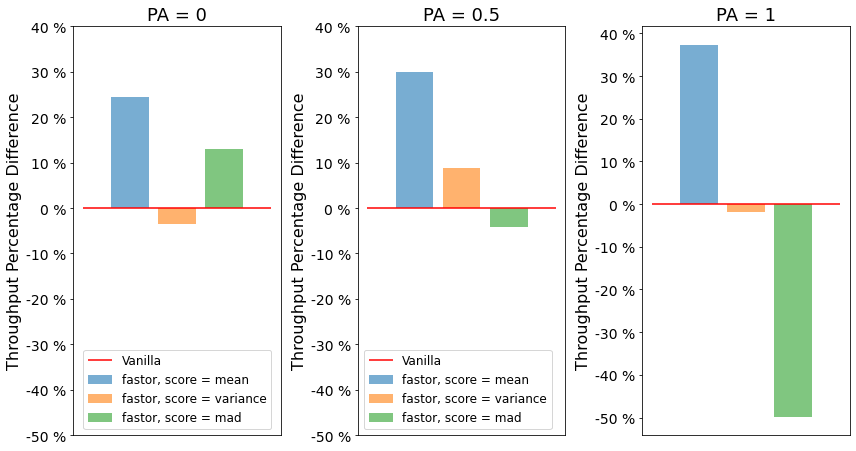

In [813]:
## Graph TTLBs of schemes

f, ax = plt.subplots(1, 3, figsize=(12,7))
# f.suptitle("Mean Throughput Difference from Vanilla", fontsize=20)

ax[0].hlines(0, 1, 5, label='Vanilla', color='red')
ax[1].hlines(0, 1, 5, label='Vanilla', color='red')
ax[2].hlines(0, 1, 5, label='Vanilla', color='red')

# PA = 0
# plotBar(ax[0], 1, ttlb_vanilla, label='vanilla')
plotBar(ax[0], 2, -1*ttlb_mean_0, label='fastor, score = mean')
plotBar(ax[0], 3, -1*ttlb_var_0, label='fastor, score = variance')
plotBar(ax[0], 4, -1*ttlb_mad_0, label='fastor, score = mad')
ax[0].set_title('PA = 0', size=18)
ax[0].set_ylabel("Throughput Percentage Difference", size=16)
ax[0].set_yticks([x*10 for x in range(-5, 5, 1)])
ax[0].set_yticklabels([f"{x*10} %" for x in range(-5, 5, 1)])
ax[0].set_xticks([])
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend(loc='lower center', fontsize=12)


# PA = 0.5
# plotBar(ax[1], 1, ttlb_vanilla, label='vanilla')
plotBar(ax[1], 2, -1*ttlb_mean_05, label='fastor, score = mean')
plotBar(ax[1], 3, -1*ttlb_var_05, label='fastor, score = variance')
plotBar(ax[1], 4, -1*ttlb_mad_05, label='fastor, score = mad')
ax[1].set_title('PA = 0.5', size=18)
ax[1].set_ylabel("Throughput Percentage Difference", size=16)
ax[1].set_yticks([x*10 for x in range(-5, 5, 1)])
ax[1].set_yticklabels([f"{x*10} %" for x in range(-5, 5, 1)])
ax[1].set_xticks([])
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].legend(fontsize=12)


# PA = 1
# plotBar(ax[2], 1, ttlb_vanilla, label='vanilla')
plotBar(ax[2], 2, -1*ttlb_mean_1, label='fastor, score = mean')
plotBar(ax[2], 3, -1*ttlb_var_1, label='fastor, score = variance')
plotBar(ax[2], 4, -1*ttlb_mad_1, label='fastor, score = mad')
ax[2].set_title('PA = 1', size=18)
ax[2].set_ylabel("Throughput Percentage Difference", size=16)
ax[2].set_yticks([x*10 for x in range(-5, 5, 1)])
ax[2].set_yticklabels([f"{x*10} %" for x in range(-5, 5, 1)])
ax[2].set_xticks([])
ax[2].tick_params(axis='both', which='major', labelsize=14)
# ax[2].legend(loc='lower left')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.savefig('../graphics/throughput_results_perc.png')

plt.show()

## Jitter

In [819]:
df_ev[df_ev[SCHEME]=="vanilla"].sort_values(SITE).reset_index()

,level_0,index,website,times,reps,mean,standard deviation,scheme,score,PA,Pool Size
0,5,444,000webhost.com,"[0.15489888191223145, 0.3837721347808838, 0.45...",36,0.419549,0.279339,vanilla,-,-1.0,-1
1,12,117,4shared.com,"[2.0601065158843994, 0.4920539855957031, 0.726...",37,1.048139,1.509656,vanilla,-,-1.0,-1
2,20,373,a8.net,"[1.5148632526397705, 1.078683614730835, 0.6871...",37,0.974579,0.808147,vanilla,-,-1.0,-1
3,35,250,abc.es,"[0.419971227645874, 0.6005058288574219, 0.6374...",37,0.524889,0.482174,vanilla,-,-1.0,-1
4,43,299,abc.net.au,"[1.6904096603393555, 0.9617788791656494, 0.891...",37,0.997554,0.268549,vanilla,-,-1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...
455,4550,1,youtube.com,"[0.24782729148864746, 1.091465950012207, 0.429...",37,0.442943,0.266669,vanilla,-,-1.0,-1
456,4569,366,zdnet.com,"[0.5565848350524902, 0.5127789974212646, 0.649...",37,0.838674,1.084647,vanilla,-,-1.0,-1
457,4574,402,zeit.de,"[0.2717432975769043, 1.3093042373657227, 1.109...",36,1.161735,1.079997,vanilla,-,-1.0,-1
458,4589,335,zendesk.com,"[1.4211859703063965, 0.43369317054748535, 0.51...",37,0.554498,0.226759,vanilla,-,-1.0,-1


In [818]:
 df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==0)].sort_values(SITE).reset_index()

,level_0,index,website,times,reps,mean,standard deviation,scheme,score,PA,Pool Size
0,8,904,000webhost.com,"[0.28328871726989746, 0.1759195327758789, 0.29...",63,0.308221,0.221572,fastor,mean,0.0,5
1,16,577,4shared.com,"[0.4717228412628174, 0.6069748401641846, 0.535...",64,0.554550,0.158717,fastor,mean,0.0,5
2,26,833,a8.net,"[0.7306821346282959, 0.7001321315765381, 0.912...",63,1.121205,2.039014,fastor,mean,0.0,5
3,30,709,abc.es,"[0.4809384346008301, 0.1504230499267578, 0.225...",64,0.306983,0.142242,fastor,mean,0.0,5
4,40,759,abc.net.au,"[0.9317619800567627, 1.01932954788208, 0.85852...",64,1.044795,1.130729,fastor,mean,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...
455,4555,461,youtube.com,"[0.1783914566040039, 0.23966217041015625, 0.30...",64,0.266405,0.088831,fastor,mean,0.0,5
456,4563,826,zdnet.com,"[0.2744464874267578, 0.5367088317871094, 0.401...",63,0.533967,0.646622,fastor,mean,0.0,5
457,4573,862,zeit.de,"[0.2663288116455078, 0.6088416576385498, 2.592...",63,0.633808,0.812503,fastor,mean,0.0,5
458,4582,795,zendesk.com,"[0.3591761589050293, 0.48418498039245605, 0.35...",64,0.482116,0.329024,fastor,mean,0.0,5


In [821]:
df_ev[df_ev[SCHEME]=="vanilla"].sort_values(SITE).reset_index()[STD].mean()

0.5768113693389468

In [825]:
df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==0)].sort_values(SITE).reset_index()[STD].mean()

0.3954215739852062

In [815]:
ttlb_vanilla_j = df_ev[df_ev[SCHEME]=="vanilla"].sort_values(SITE).reset_index()[STD]

ttlb_mean_0_j = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==0)].sort_values(SITE).reset_index()[STD])
ttlb_mean_05_j = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==0.5)].sort_values(SITE).reset_index()[STD])
ttlb_mean_1_j = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==MEAN) & (df_ev[PA]==1)].sort_values(SITE).reset_index()[STD])

ttlb_var_0_j = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==0)].sort_values(SITE).reset_index()[STD])
ttlb_var_05_j = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==0.5)].sort_values(SITE).reset_index()[STD])
ttlb_var_1_j = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]==VARIANCE) & (df_ev[PA]==1)].sort_values(SITE).reset_index()[STD])

ttlb_mad_0_j = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==0)].sort_values(SITE).reset_index()[STD])
ttlb_mad_05_j = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==0.5)].sort_values(SITE).reset_index()[STD])
ttlb_mad_1_j = getPercDifference(ttlb_vanilla, df_ev[(df_ev[SCHEME]=="fastor") & (df_ev[SCORE]=='mad') & (df_ev[PA]==1)].sort_values(SITE).reset_index()[STD])

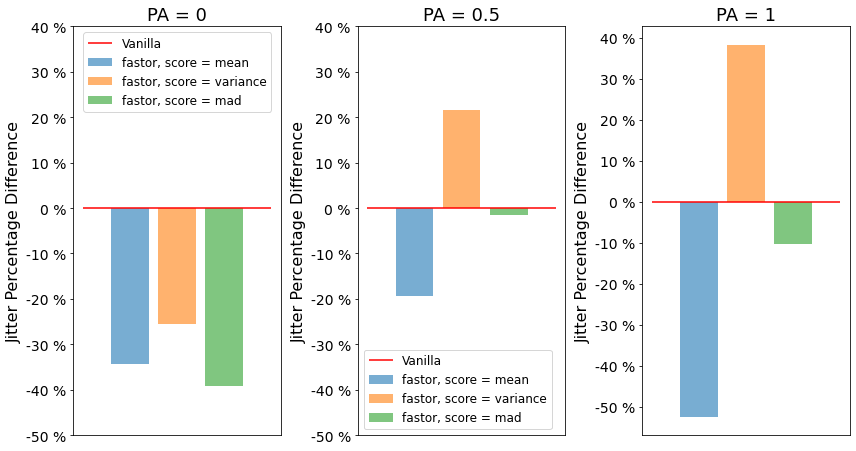

In [828]:
## Graph TTLBs of schemes

f, ax = plt.subplots(1, 3, figsize=(12,7))
# f.suptitle("Mean Throughput Difference from Vanilla", fontsize=20)

ax[0].hlines(0, 1, 5, label='Vanilla', color='red')
ax[1].hlines(0, 1, 5, label='Vanilla', color='red')
ax[2].hlines(0, 1, 5, label='Vanilla', color='red')

# PA = 0
# plotBar(ax[0], 1, ttlb_vanilla, label='vanilla')
plotBar(ax[0], 2, ttlb_mean_0_j, label='fastor, score = mean')
plotBar(ax[0], 3, ttlb_var_0_j, label='fastor, score = variance')
plotBar(ax[0], 4, ttlb_mad_0_j, label='fastor, score = mad')
ax[0].set_title('PA = 0', size=18)
ax[0].set_ylabel("Jitter Percentage Difference", size=16)
ax[0].set_yticks([x*10 for x in range(-5, 5, 1)])
ax[0].set_yticklabels([f"{x*10} %" for x in range(-5, 5, 1)])
ax[0].set_xticks([])
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend(loc='upper center', fontsize=12)


# PA = 0.5
# plotBar(ax[1], 1, ttlb_vanilla, label='vanilla')
plotBar(ax[1], 2, ttlb_mean_05_j, label='fastor, score = mean')
plotBar(ax[1], 3, ttlb_var_05_j, label='fastor, score = variance')
plotBar(ax[1], 4, ttlb_mad_05_j, label='fastor, score = mad')
ax[1].set_title('PA = 0.5', size=18)
ax[1].set_ylabel("Jitter Percentage Difference", size=16)
ax[1].set_yticks([x*10 for x in range(-5, 5, 1)])
ax[1].set_yticklabels([f"{x*10} %" for x in range(-5, 5, 1)])
ax[1].set_xticks([])
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].legend(fontsize=12)


# PA = 1
# plotBar(ax[2], 1, ttlb_vanilla, label='vanilla')
plotBar(ax[2], 2, ttlb_mean_1_j, label='fastor, score = mean')
plotBar(ax[2], 3, ttlb_var_1_j, label='fastor, score = variance')
plotBar(ax[2], 4, ttlb_mad_1_j, label='fastor, score = mad')
ax[2].set_title('PA = 1', size=18)
ax[2].set_ylabel("Jitter Percentage Difference", size=16)
ax[2].set_yticks([x*10 for x in range(-5, 5, 1)])
ax[2].set_yticklabels([f"{x*10} %" for x in range(-5, 5, 1)])
ax[2].set_xticks([])
ax[2].tick_params(axis='both', which='major', labelsize=14)
# ax[2].legend(loc='lower left')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.savefig('../graphics/jitter_results_perc.png')

plt.show()